# 1. Audio -> Spectrogram

Loading a 5-sec clip and converting it to a spectrogram

In [35]:
import librosa as librosa
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import librosa.display
from tqdm.notebook import tqdm
import warnings  
warnings.filterwarnings('ignore') # Librosa's specshow gives warnings about a matplotlib deprecation thing

In [36]:
# Get a list of audio recordings
train_files = glob.glob('Downloads/train_short_audio/*/*.ogg')
train_files[0]

'Downloads/train_short_audio\\acafly\\XC109605.ogg'

We want to go from a 5-second clip to a spectrogram, ideally one that captures as much info as possible. Enter librosa and the mel spectrogram

In [37]:
# Load 5 seconds of audio
chunk, rate = librosa.load(train_files[0], sr=32000, offset=3, duration=5)

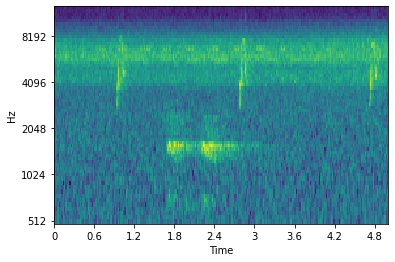

In [47]:
def chunk_to_spec(chunk, SPEC_HEIGHT=64,SPEC_WIDTH=256, rate=32000, FMIN=500, FMAX=12500):
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=32000, 
                                              n_fft=1024, 
                                              hop_length=int(32000 * 5 / (SPEC_WIDTH - 1)), 
                                              n_mels=SPEC_HEIGHT, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def display_spec(spec, SPEC_HEIGHT=64,SPEC_WIDTH=256, rate=32000, FMIN=500, FMAX=12500):
    librosa.display.specshow(spec, 
                             sr=32000, 
                             hop_length=int(32000 * 5 / (SPEC_WIDTH - 1)), 
                             x_axis='time', 
                             y_axis='mel',
                             fmin=FMIN, 
                             fmax=FMAX, 
                             cmap=plt.get_cmap('viridis'))
    
spec = chunk_to_spec(chunk)
display_spec(spec) # Will give axis labels in Hs and time

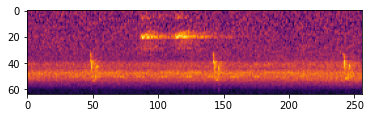

In [48]:
plt.imshow(spec, cmap='inferno') # Simple and compact

# 2. Picking the right chunks for training

In [39]:
def peak_plot(y, sr, FMIN=500, FMAX=12500):
    # PCEN spec
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    melspec = librosa.feature.melspectrogram(y, sr=sr,
        fmin=FMIN, fmax=FMAX, n_mels=64)
    pcen = librosa.core.pcen(melspec, sr=sr,
        gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
    librosa.display.specshow(pcen, sr=sr,
        fmin=FMIN, fmax=FMAX,
        x_axis='time', y_axis='mel', cmap='magma_r')
    # plt.title('PCEN-based SNR')
    plt.tight_layout()

    # SNR and a smoothed SNR with kernel 15
    plt.subplot(3, 1, 2)
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=15)
    times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
    plt.plot(times, pcen_snr, color="orange")
    plt.plot(times, median_pcen_snr, color="blue")
    plt.xlim(times[0], times[-1])
    plt.ylim(0, 10)
    # And go through, picking some peaks
    for i in range(12):
        t_peak = np.argmax(median_pcen_snr)
        plt.scatter(times[t_peak], median_pcen_snr[t_peak], c='red', zorder=100)
        median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one

    # Kernel 55 for even smoother (bad idea?)
    plt.subplot(3, 1, 3)
    median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=55)
    times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
    plt.plot(times, median_pcen_snr, color="blue")
    plt.xlim(times[0], times[-1])
    plt.ylim(0, 10)
    # And go through, picking some peaks
    for i in range(12):
        t_peak = np.argmax(median_pcen_snr)
        plt.scatter(times[t_peak], median_pcen_snr[t_peak], c='red', zorder=100)
        median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one

In [40]:
from IPython.display import Audio
Audio(train_files[0])

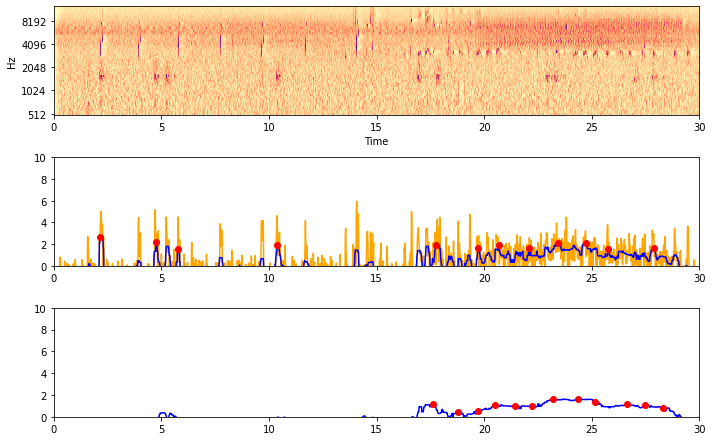

In [41]:
y, sr = librosa.load(train_files[0], sr=32000, duration=30) # 30 seconds to play with
peak_plot(y, sr)

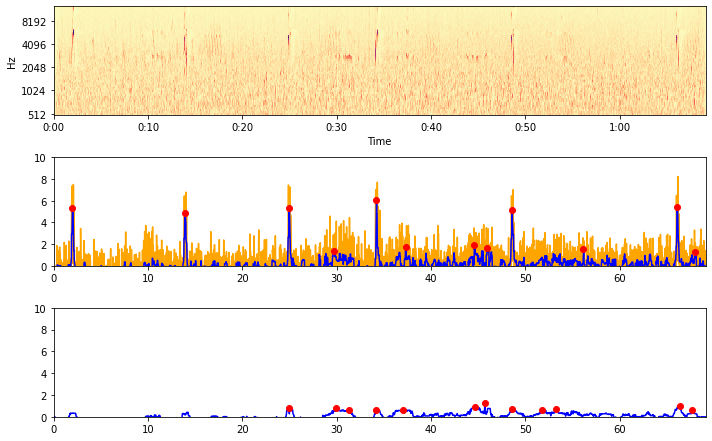

In [45]:
y, sr = librosa.load(train_files[100], sr=32000) # A whole recording
peak_plot(y, sr)

In [49]:
Audio(train_files[100])

In [52]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]
spectral_centroids.shape

(4320,)

In [54]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

In [56]:
def normalize(y, axis=0):
    return sklearn.preprocessing.minmax_scale(y, axis=axis)

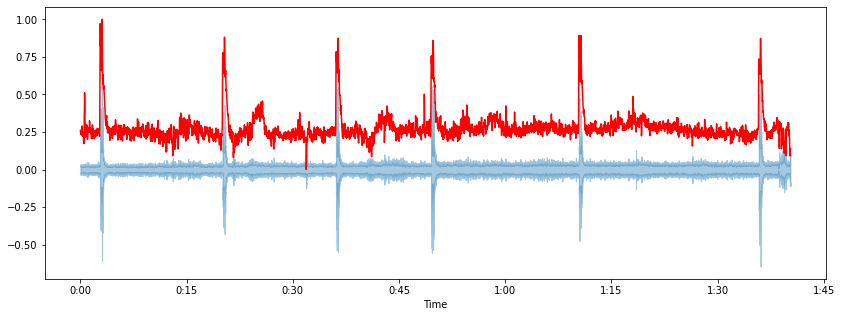

In [81]:
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
librosa.display.waveshow(y, sr=sr, alpha=0.4)

In [43]:
def get_peaks(y, sr, n_peaks=12, kernel_size=15, zero_dist=50, FMIN=500, FMAX=12500):
    # Spec
    melspec = librosa.feature.melspectrogram(y, sr=sr,
        fmin=FMIN, fmax=FMAX, n_mels=64)
    pcen = librosa.core.pcen(melspec, sr=sr,
        gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
    # SNR
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    # SMoothed SNR
    median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    # And go through, picking some peaks
    times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
    peak_locs = []
    for i in range(n_peaks):
        t_peak = np.argmax(median_pcen_snr)
        peak_locs.append(times[t_peak])
        median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one

    return peak_locs

print(get_peaks(y, sr, n_peaks=5))

[34.22647626765455, 66.0847811993517, 24.961805973605, 2.0001447094234774, 48.59551586015281]


# 3. Storing Peak Locations and Labels for Later

This takes a while to run, so we save the locations of 20 peaks per recording which we can then use in other notebooks down the road

In [44]:
info = []
for f in tqdm(train_files):
    y, sr = librosa.load(f, sr=32000)
    peaks =  get_peaks(y, sr, n_peaks=20)
    info.append({
        'fn':f,
        'len':len(y), 
        'label':f.split('Downloads/train_short_audio/')[1].split('/')[0],
        'peaks':'#'.join([str(p)[:5] for p in peaks]),  
    })
    
# Save to file        
    info_df = pd.DataFrame(info)
    info_df.to_csv('info_df.csv', index=False)
    info_df.head()

  0%|          | 0/23606 [00:00<?, ?it/s]

IndexError: list index out of range

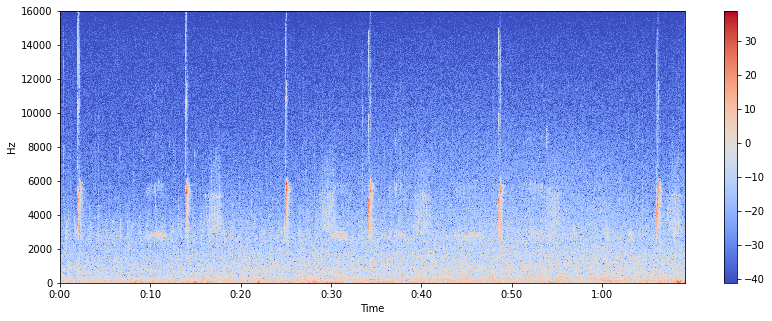

In [68]:
#display Spectrogram
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

Text(0.5, 1.0, 'Bird')

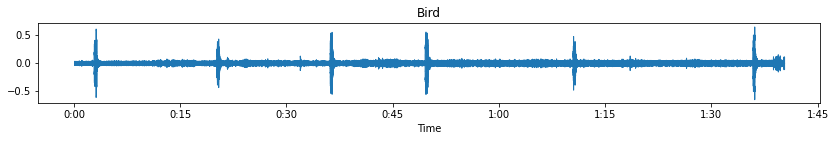

In [83]:
import matplotlib.pyplot as plt
x, sr = librosa.load(train_files[0])
#Plot the signal:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Bird')

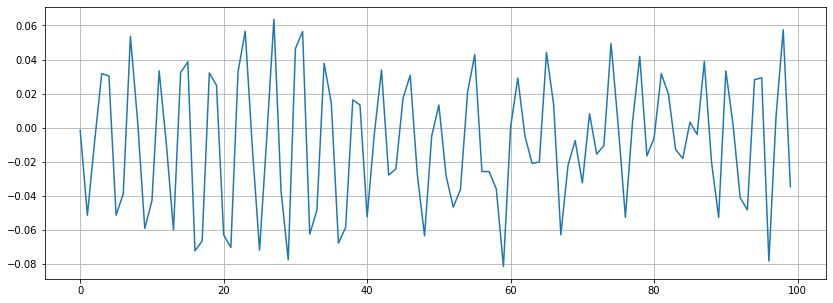

In [73]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

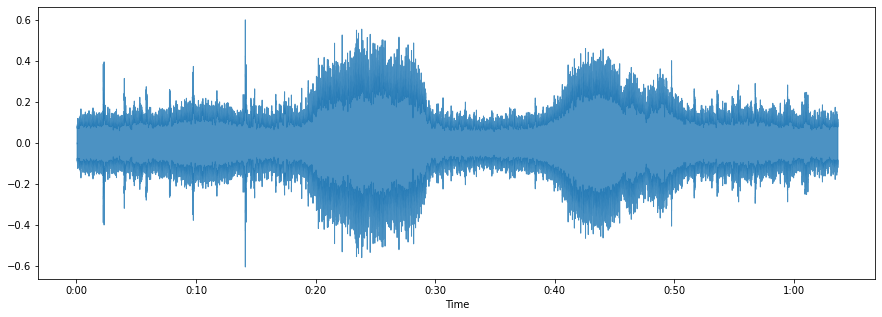

In [79]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr, alpha=0.8)

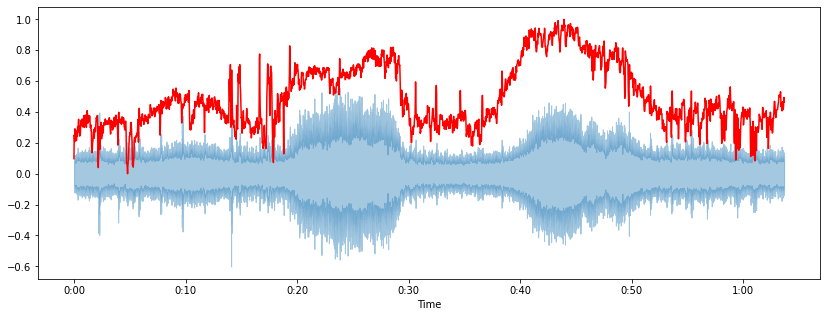

In [87]:
spectral_centroids = librosa.feature.spectral_centroid(x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

# Spectral Bandwidth

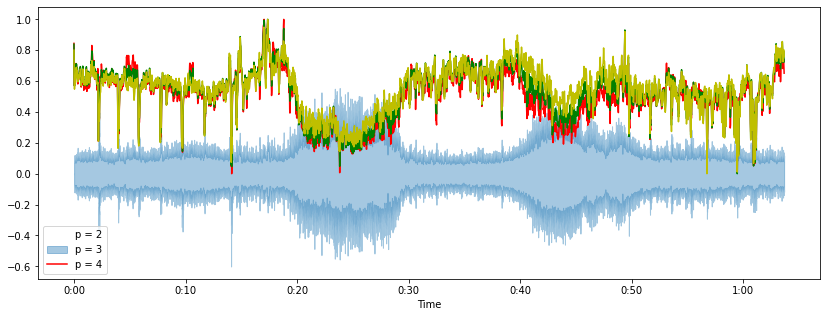

In [89]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

# Spectral Contrast

In [90]:
spectral_contrast = librosa.feature.spectral_contrast(x, sr=sr)
spectral_contrast.shape

(7, 2743)

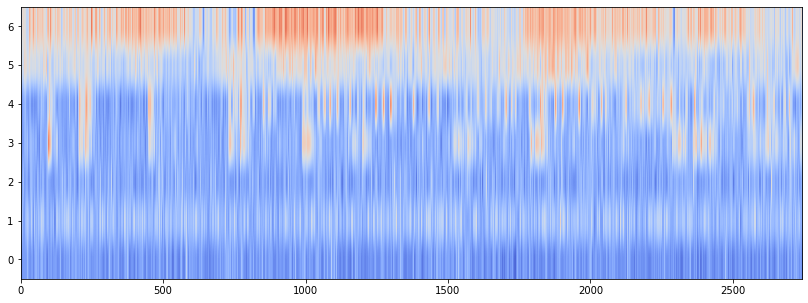

In [91]:
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')

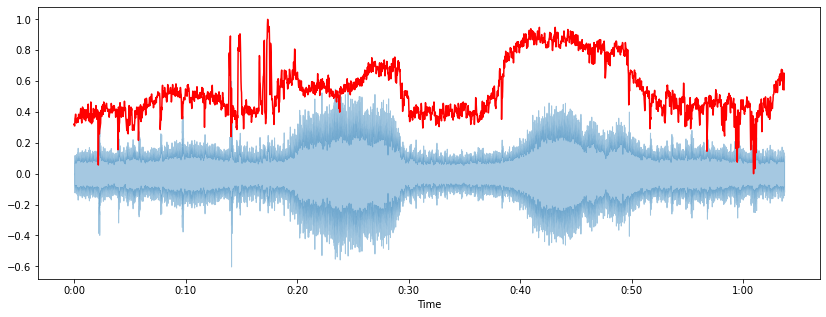

In [92]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')